# Library Imports

In [1]:
import glob
import os
import sumo_rl

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import xml.etree.ElementTree as ET

from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv

Using libsumo as traci as requested by environment variable.


# Configuration

## General Config

In [3]:
# Trip files generated by `sumo`, used during analysis and hypothesis testing
BASELINE_PATTERN = "baseline_trip_*.xml"
RL_PATTERN = "rl_trip_*.xml"

## Environment Config

In [2]:
# Force the environment to use `libsumo` in place of `traci` (speeds up simulations)
os.environ['LIBSUMO_AS_TRACI'] = '1'

## Model Config

# Modified Environment

Changes: Different reward function

In [3]:
class FairnessRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.prev_accumulated_waits = None

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        ts_id = self.env.unwrapped.ts_ids[0]
        ts = self.env.unwrapped.traffic_signals[ts_id]
        self.prev_accumulated_waits = np.array(
            ts.get_accumulated_waiting_time_per_lane(), dtype=np.float32
        )
        return obs, info

    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)
        ts_id = self.env.unwrapped.ts_ids[0]
        ts = self.env.unwrapped.traffic_signals[ts_id]

        # Get current accumulated waits
        current_waits = np.array(
            ts.get_accumulated_waiting_time_per_lane(), dtype=np.float32
        )
        
        if self.prev_accumulated_waits is None:
            self.prev_accumulated_waits = current_waits
        
        # Calculate NEW wait time added this step (delta)
        new_waits = np.maximum(current_waits - self.prev_accumulated_waits, 0)
        self.prev_accumulated_waits = current_waits.copy()

        if len(new_waits) == 0:
            return obs, 0.0, terminated, truncated, info

        # Penalize total new waiting
        total_wait_penalty = -np.sum(new_waits) / 100.0
        
        # STRONG fairness penalty: penalize the MAXIMUM lane wait
        # This prevents the agent from ignoring any single lane
        max_lane_penalty = -3.0 * np.max(new_waits) / 100.0
        
        # Optional: Add std deviation penalty for balance
        fairness_penalty = -np.std(new_waits) / 50.0 if np.sum(new_waits) > 0 else 0
        
        reward = total_wait_penalty + max_lane_penalty + fairness_penalty
        reward = np.clip(reward, -10.0, 0.0)

        return obs, reward, terminated, truncated, info

In [4]:
class WaitTimeObservationFunction(sumo_rl.ObservationFunction):
    def __init__(self, ts):
        super().__init__(ts)

    def __call__(self):
        queues = self.ts.get_lanes_queue()
        # Normalize waits per lane (prevents explosion)
        waits = [min(w / 100.0, 5.0) for w in self.ts.get_accumulated_waiting_time_per_lane()]
        
        phase_id = [1 if self.ts.green_phase == i else 0 
                   for i in range(self.ts.num_green_phases)]
        
        # Add time since phase changed (helps agent know when to switch)
        time_since_change = [min(self.ts.time_since_last_phase_change / 60.0, 1.0)]
        
        return np.array(phase_id + queues + waits + time_since_change, dtype=np.float32)

    def observation_space(self):
        num_features = self.ts.num_green_phases + (len(self.ts.lanes) * 2) + 1
        return gym.spaces.Box(low=0, high=np.inf, shape=(num_features,), dtype=np.float32)

In [5]:
def make_env():
    import sumo_rl
    import gymnasium as gym
    
    env = gym.make('sumo-rl-v0',
                   net_file='quimpo-GE_torres.net.xml',
                   route_file='quimpo_traffic_route.rou.xml',
                   use_gui=False,
                   num_seconds=14400, 
                   delta_time=20,
                   yellow_time=5,
                   observation_class=WaitTimeObservationFunction,
                   additional_sumo_cmd="--additional-files vehicle_types.add.xml")
    env = FairnessRewardWrapper(env)
    return env

# Training Script

In [6]:
vec_env = make_vec_env(make_env, n_envs=4, vec_env_cls=SubprocVecEnv)

model = DQN('MlpPolicy',
            vec_env, 
            verbose=1,
            buffer_size=50000,  # Smaller buffer for faster learning
            learning_starts=2000,
            target_update_interval=1000,
            max_grad_norm=0.5,  # Stricter gradient clipping
            exploration_fraction=0.4,  # Explore longer
            exploration_final_eps=0.05,  # Keep some exploration
            gamma=0.95,  # Lower gamma - prioritize immediate fairness
            learning_rate=0.0001,
            policy_kwargs={'net_arch': [128, 128]},  # Simpler network
            tensorboard_log="./tensorboard_logs/")

model.learn(total_timesteps=100000)
model.save("model")
print("Training Complete")

Using cpu device
Logging to ./tensorboard_logs/DQN_44
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 720      |
|    ep_rew_mean      | -1.5e+03 |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 406      |
|    time_elapsed     | 7        |
|    total_timesteps  | 2880     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 54       |
----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 720       |
|    ep_rew_mean      | -1.47e+03 |
|    exploration_rate | 0.863     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 392       |
|    time_elapsed     | 14        |
|    total_timesteps  | 5760      |
| train/              |           |
|    learning_rate    | 0

# Sanity Checking Script

Just to be sure we're doing it right

In [ ]:
if 'LIBSUMO_AS_TRACI' in os.environ:
    print("⚠️ Disabling LIBSUMO for GUI mode...")
    del os.environ['LIBSUMO_AS_TRACI']

env = FairnessRewardWrapper(gym.make('sumo-rl-v0',
                       net_file='quimpo-GE_torres.net.xml',
                       route_file='quimpo_traffic_route.rou.xml',
                       use_gui=True,  # <--- WE WANT TO SEE IT
                       num_seconds=86400, # You can simulate a full day now if you want
                       delta_time=20,
                       yellow_time=5,
                       observation_class=WaitTimeObservationFunction,
                       additional_sumo_cmd=f"--additional-files vehicle_types.add.xml"
                       ))

model_path = "./model.zip"

# Check if model exists
if os.path.exists(model_path):
    model = DQN.load(model_path)

    print("Starting Evaluation...")


    obs, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        # deterministic=True means "Pick the BEST action", no randomness
        action, _ = model.predict(obs, deterministic=True)

        obs, reward, terminated, truncated, info = env.step(action)

        total_reward += reward
        done = terminated or truncated
    print(f"Episode Finished. Total Accumulated Fairness Reward: {total_reward}")
    env.close()

⚠️ Disabling LIBSUMO for GUI mode...
Starting Evaluation...


# Hypothesis Testing Script

During evaluation, we will run the simulation 50 times, using different seeds (1 to 50).

In [11]:
envs = []

for i in range(1,51):
    temp = gym.make('sumo-rl-v0',
                    net_file='quimpo-GE_torres.net.xml',
                    route_file='quimpo_traffic_route.rou.xml',
                    use_gui=False,
                    num_seconds=86400,
                    delta_time=20,
                    yellow_time=5,
                    observation_class=WaitTimeObservationFunction,
                    additional_sumo_cmd=f"--additional-files vehicle_types.add.xml --tripinfo-output rl_trip_{i}.xml --seed {i}"
                   )
    env = FairnessRewardWrapper(temp)
    envs.append(env)

model_path = './model.zip'

if os.path.exists(model_path):
    model = DQN.load(model_path)
    idx = 1
    for env in envs:
        print(f'Running episode {idx}')
        obs, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            # deterministic=True means "Pick the BEST action", no randomness
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            done = terminated or truncated

        print(f"Episode Finished. Total Accumulated Fairness Reward: {total_reward}")
        env.close()
        idx += 1

Running episode 1
Episode Finished. Total Accumulated Fairness Reward: -18617.568359375
Running episode 2
Episode Finished. Total Accumulated Fairness Reward: -18560.03125
Running episode 3
Episode Finished. Total Accumulated Fairness Reward: -18493.328125
Running episode 4


Episode Finished. Total Accumulated Fairness Reward: -18610.544921875
Running episode 5
Episode Finished. Total Accumulated Fairness Reward: -18520.201171875
Running episode 6
Episode Finished. Total Accumulated Fairness Reward: -18454.205078125
Running episode 7
Episode Finished. Total Accumulated Fairness Reward: -18545.978515625
Running episode 8
Episode Finished. Total Accumulated Fairness Reward: -18563.447265625
Running episode 9
Episode Finished. Total Accumulated Fairness Reward: -18560.880859375
Running episode 10
Episode Finished. Total Accumulated Fairness Reward: -18578.1484375
Running episode 11
Episode Finished. Total Accumulated Fairness Reward: -18569.171875
Running episode 12
Episode Finished. Total Accumulated Fairness Reward: -18592.9296875
Running episode 13
Episode Finished. Total Accumulated Fairness Reward: -18428.60546875
Running episode 14
Episode Finished. Total Accumulated Fairness Reward: -18682.328125
Running episode 15
Episode Finished. Total Accumulated F

Episode Finished. Total Accumulated Fairness Reward: -18547.814453125
Running episode 24
Episode Finished. Total Accumulated Fairness Reward: -18499.232421875
Running episode 25


Episode Finished. Total Accumulated Fairness Reward: -18593.771484375
Running episode 26
Episode Finished. Total Accumulated Fairness Reward: -18567.587890625
Running episode 27
Episode Finished. Total Accumulated Fairness Reward: -18569.447265625
Running episode 28
Episode Finished. Total Accumulated Fairness Reward: -18523.21875
Running episode 29
Episode Finished. Total Accumulated Fairness Reward: -18607.087890625
Running episode 30
Episode Finished. Total Accumulated Fairness Reward: -18728.244140625
Running episode 31
Episode Finished. Total Accumulated Fairness Reward: -18554.314453125
Running episode 32
Episode Finished. Total Accumulated Fairness Reward: -18744.22265625
Running episode 33
Episode Finished. Total Accumulated Fairness Reward: -18528.958984375
Running episode 34


Episode Finished. Total Accumulated Fairness Reward: -18625.337890625
Running episode 35
Episode Finished. Total Accumulated Fairness Reward: -18535.71875
Running episode 36
Episode Finished. Total Accumulated Fairness Reward: -18491.451171875
Running episode 37
Episode Finished. Total Accumulated Fairness Reward: -18560.619140625
Running episode 38
Episode Finished. Total Accumulated Fairness Reward: -18532.4375
Running episode 39
Episode Finished. Total Accumulated Fairness Reward: -18628.2578125
Running episode 40
Episode Finished. Total Accumulated Fairness Reward: -18568.3515625
Running episode 41
Episode Finished. Total Accumulated Fairness Reward: -18494.74609375
Running episode 42
Episode Finished. Total Accumulated Fairness Reward: -18511.28515625
Running episode 43
Episode Finished. Total Accumulated Fairness Reward: -18466.599609375
Running episode 44
Episode Finished. Total Accumulated Fairness Reward: -18538.8671875
Running episode 45


Episode Finished. Total Accumulated Fairness Reward: -18513.638671875
Running episode 46
Episode Finished. Total Accumulated Fairness Reward: -18590.17578125
Running episode 47
Episode Finished. Total Accumulated Fairness Reward: -18584.3359375
Running episode 48
Episode Finished. Total Accumulated Fairness Reward: -18527.193359375
Running episode 49
Episode Finished. Total Accumulated Fairness Reward: -18651.919921875
Running episode 50
Episode Finished. Total Accumulated Fairness Reward: -18579.607421875


# Hypothesis Testing

In [4]:
def extract_waiting_times(file_pattern):
    """
    Parses all XML files matching the pattern and extracts
    the 'waitingTime' for every single vehicle.
    """
    files = glob.glob(file_pattern)
    all_wait_times = []
    
    if not files:
        print(f"⚠️ No files found for pattern: {file_pattern}")
        return np.array([])

    print(f"Loading {len(files)} files for pattern '{file_pattern}'...")
    
    for file in files:
        try:
            tree = ET.parse(file)
            root = tree.getroot()
            # 'tripinfo' tag contains 'waitingTime' attribute
            # We explicitly cast to float
            waits = [float(trip.get('waitingTime')) for trip in root.findall('tripinfo')]
            all_wait_times.extend(waits)
        except Exception as e:
            print(f"Error parsing {file}: {e}")

    return np.array(all_wait_times)

--- Loading Data ---
Loading 50 files for pattern 'baseline_trip_*.xml'...
Loading 50 files for pattern 'rl_trip_*.xml'...

--- Descriptive Statistics (Waiting Time in seconds) ---
Metric               | Baseline        | RL Model       
--------------------------------------------------------
Count (Vehicles)     | 2263330         | 2500903        
Mean                 | 69.4706          | 36.1084
Median               | 53.0000          | 26.0000
Std Dev              | 72.6134          | 48.3377
Max Wait             | 1792.0000          | 762.0000

--- Normality Check (Shapiro-Wilk) ---
Baseline Normality p-value: 0.00000 (Not Normal)
RL Model Normality p-value: 0.00000 (Not Normal)

--- Hypothesis Test ---
Distribution is Non-Normal. Using Mann-Whitney U Test.
Test: Mann-Whitney U
Statistic: 3048230035681.5000
P-Value:   0.0000000000

✅ RESULT: SIGNIFICANT DIFFERENCE FOUND
The RL model performs significantly better (lower waiting times) than the baseline.

--- Fairness Check (100th P

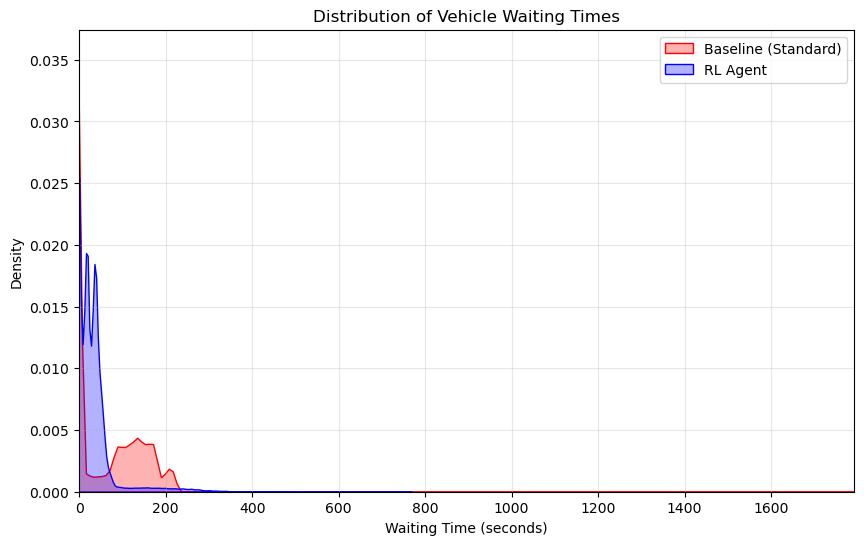

In [7]:
print("--- Loading Data ---")
baseline_waits = extract_waiting_times(BASELINE_PATTERN)
rl_waits = extract_waiting_times(RL_PATTERN)

if len(baseline_waits) == 0 or len(rl_waits) == 0:
    print("Error: Not enough data to compare. Make sure XML files exist.")
    raise ValueError()

# 2. Descriptive Statistics
print("\n--- Descriptive Statistics (Waiting Time in seconds) ---")
print(f"{'Metric':<20} | {'Baseline':<15} | {'RL Model':<15}")
print("-" * 56)
print(f"{'Count (Vehicles)':<20} | {len(baseline_waits):<15} | {len(rl_waits):<15}")
print(f"{'Mean':<20} | {np.mean(baseline_waits):.4f}          | {np.mean(rl_waits):.4f}")
print(f"{'Median':<20} | {np.median(baseline_waits):.4f}          | {np.median(rl_waits):.4f}")
print(f"{'Std Dev':<20} | {np.std(baseline_waits):.4f}          | {np.std(rl_waits):.4f}")
print(f"{'Max Wait':<20} | {np.max(baseline_waits):.4f}          | {np.max(rl_waits):.4f}")

# 3. Normality Test (Shapiro-Wilk)
# Note: If N > 5000, Shapiro is often too sensitive. We use it here for formality,
# but traffic data is almost never normal (it's usually Log-Normal).
print("\n--- Normality Check (Shapiro-Wilk) ---")
    
# We take a random sample if data is huge to keep Shapiro valid
sample_size = min(4000, len(baseline_waits), len(rl_waits))
base_sample = np.random.choice(baseline_waits, sample_size, replace=False)
rl_sample = np.random.choice(rl_waits, sample_size, replace=False)

_, p_base = stats.shapiro(base_sample)
_, p_rl = stats.shapiro(rl_sample)

print(f"Baseline Normality p-value: {p_base:.5f} ({'Normal' if p_base > 0.05 else 'Not Normal'})")
print(f"RL Model Normality p-value: {p_rl:.5f} ({'Normal' if p_rl > 0.05 else 'Not Normal'})")

# 4. Hypothesis Testing
print("\n--- Hypothesis Test ---")
    
# If both are normal, use T-Test. Otherwise, Mann-Whitney U.
if p_base > 0.05 and p_rl > 0.05:
    print("Distribution is Normal. Using Welch's T-Test.")
    stat, p_val = stats.ttest_ind(baseline_waits, rl_waits, equal_var=False)
    test_name = "Welch's T-Test"
else:
    print("Distribution is Non-Normal. Using Mann-Whitney U Test.")
    # alternative='greater' means we test if Baseline > RL (i.e., RL reduced the time)
    stat, p_val = stats.mannwhitneyu(baseline_waits, rl_waits, alternative='greater')
    test_name = "Mann-Whitney U"

print(f"Test: {test_name}")
print(f"Statistic: {stat:.4f}")
print(f"P-Value:   {p_val:.10f}")

alpha = 0.05
if p_val < alpha:
    print("\n✅ RESULT: SIGNIFICANT DIFFERENCE FOUND")
    print("The RL model performs significantly better (lower waiting times) than the baseline.")
else:
    print("\n❌ RESULT: NO SIGNIFICANT DIFFERENCE")
    print("We cannot reject the null hypothesis. The improvements might be due to chance.")

base_100 = np.percentile(baseline_waits, 100)
rl_100 = np.percentile(rl_waits, 100)

print(f"\n--- Fairness Check (100th Percentile) ---")
print(f"Baseline 100% wait: {base_100:.2f}s")
print(f"RL Model 100% wait: {rl_100:.2f}s")
    
if rl_100 > base_100 * 1.5:
    print("⚠️ CRITICAL FAILURE: The RL Model is starving specific lanes (Unfair).")
    print("   The 99th percentile wait time is significantly worse.")
elif rl_100 < base_100:
    print("✅ FAIRNESS IMPROVEMENT: The RL Model reduced extreme waiting times.")
else:
    print("⚖️ FAIRNESS NEUTRAL.")

# 5. Visualization
print("\nGenerating Histogram...")
plt.figure(figsize=(10, 6))
sns.kdeplot(baseline_waits, fill=True, label='Baseline (Standard)', color='red', alpha=0.3)
sns.kdeplot(rl_waits, fill=True, label='RL Agent', color='blue', alpha=0.3)
plt.title('Distribution of Vehicle Waiting Times')
plt.xlabel('Waiting Time (seconds)')
plt.xlim(0, max(np.percentile(baseline_waits, 100), np.percentile(rl_waits, 100))) # Cut off extreme outliers for view
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("comparison_plot.png")
print("Plot saved to 'comparison_plot.png'")